# 주식등락예측하기 (머신러닝)

과거의 데이터들로 학습을 하여 그날의 데이터로 다음의 종가는 상승할 것인지 하락할 것인지를 맞추는 경우입니다.

주식관련 보조지표들과 감성분석한 데이터들을 이용하여 종목별 적합한 추세에 사용하기에 좋은 전략을 찾아내고자 합니다.

In [1]:
# 기본적으로 필요한 라이브러리
import numpy as np
import pandas as pd


#시각화 라이브러리
import matplotlib.pyplot as plt 
import seaborn as sns

#datetime 형식으로 바꿔주는 라이브러리
from datetime import datetime

import timeit #데이터를 가져오는 데 얼마나 시간이 걸리는지 확인하기 위한 라이브러리

# 1. 고가, 저가, 시가, 종가, 거래량으로 다음 종가 등락 예측

In [2]:
stock = pd.read_csv('hanjin_stock.csv')

In [3]:
stock_1 = stock.copy()

stock 데이터는 최근부터 오래된순으로 정렬되어있어서

오래된순으로 재정렬하며, 칼럼과 인덱스를 수정하는 작업을 한다.

In [4]:
# 날짜 데이터를 datetime 형식으로 바꾸고 순서 재정렬
stock_1['날짜'] = stock_1['날짜'].map(lambda x : datetime.strptime(x, "%Y.%m.%d"))
stock_1 = stock_1.sort_values('날짜')

#컬럼명을 영어로 바꿈
stock_1.columns = ['date', 'close', 'diff' , 'start', 'high' ,'low', 'volume']

stock_1 = stock_1.set_index('date') # date를 index로 설정
stock_1 = stock_1.loc['2018-05-21' : '2019-05-20']

In [5]:
stock_1.head()

,close,diff,start,high,low,volume
date,,,,,,
2018-05-21,25900.0,400.0,26100.0,26250.0,25650.0,43282.0
2018-05-23,25250.0,650.0,25800.0,26000.0,24950.0,43708.0
2018-05-24,25200.0,50.0,25400.0,25650.0,24950.0,20510.0
2018-05-25,24700.0,500.0,24800.0,25100.0,24550.0,48502.0
2018-05-28,25200.0,500.0,25100.0,25850.0,25050.0,46162.0


In [6]:
stock_1.tail()

,close,diff,start,high,low,volume
date,,,,,,
2019-05-14,44300.0,1900.0,42350.0,45150.0,41800.0,231081.0
2019-05-15,44900.0,600.0,44750.0,46000.0,44000.0,162316.0
2019-05-16,43500.0,1400.0,44900.0,45700.0,43250.0,110606.0
2019-05-17,43200.0,300.0,44000.0,44100.0,41000.0,237329.0
2019-05-20,43650.0,450.0,42600.0,44700.0,42150.0,114412.0


한진 데이터는 2018년 5월 21일부터 2019년 5월 20일까지의 데이터를 활용하여 총 243개의 데이터

종가, 시가, 고가, 저가, 거래량으로 Accuracy를 확인하고자 한다.

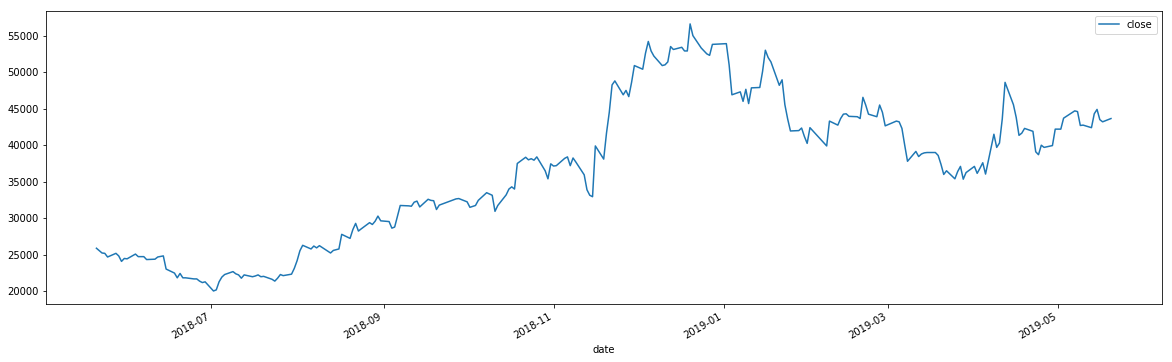

In [7]:
stock_1[['close']].plot(figsize = (20,6))
plt.show()

## 1.1 머신러닝 준비하기

주식 등락을 예측하기위해 오늘의 종가와 내일의 종가를 보고 내일 종가가 오르거나 그대로면 1, 그렇지않으면 0

In [8]:
def up_down(x):
    if x >= 0:
        return 1
    else :
        return 0

stock_1['fluctuation'] = (stock_1['close'].shift(-1)-stock_1['close']).apply(up_down)
stock_1.drop('diff', axis=1, inplace=True)
stock_1.head()

,close,start,high,low,volume,fluctuation
date,,,,,,
2018-05-21,25900.0,26100.0,26250.0,25650.0,43282.0,0
2018-05-23,25250.0,25800.0,26000.0,24950.0,43708.0,0
2018-05-24,25200.0,25400.0,25650.0,24950.0,20510.0,0
2018-05-25,24700.0,24800.0,25100.0,24550.0,48502.0,1
2018-05-28,25200.0,25100.0,25850.0,25050.0,46162.0,0


In [9]:
stock_1.tail()

,close,start,high,low,volume,fluctuation
date,,,,,,
2019-05-14,44300.0,42350.0,45150.0,41800.0,231081.0,1
2019-05-15,44900.0,44750.0,46000.0,44000.0,162316.0,0
2019-05-16,43500.0,44900.0,45700.0,43250.0,110606.0,0
2019-05-17,43200.0,44000.0,44100.0,41000.0,237329.0,1
2019-05-20,43650.0,42600.0,44700.0,42150.0,114412.0,0


추후 보조지표 활용 분석에 사용 될 데이터의 갯수를 맞춰 주기위해 slicing을 함

In [10]:
print('기존의 데이터 갯수 :', len(stock_1))
print('최소한의 데이터 갯수 : ', len(stock_1.iloc[len(stock_1)-205:]))
stock_1_205 = stock_1.iloc[len(stock_1)-205:]

기존의 데이터 갯수 : 243
최소한의 데이터 갯수 :  205


마지막 20일 같은 경우는 원래는 Nan 값으로 따로 빼서 직접적으로 확인 해보며,

test를 해보기 위해 7:3으로 데이터를 나누고, 주가는 시계열데이터로 시간의 영향이 들어갈 수 있도록 shuffle은 하지 않는다.

In [11]:
from sklearn.model_selection import train_test_split

today = stock_1_205.iloc[-1]
stock_1_df = stock_1_205.iloc[:-1]
target = stock_1_df['fluctuation']
stock_1_df = stock_1_df.drop('fluctuation', axis = 1)

train, test, train_target, test_target = train_test_split(stock_1_df, target, test_size = 0.3, shuffle=False )

In [12]:
train.head()

,close,start,high,low,volume
date,,,,,
2018-07-17,22100.0,21750.0,22300.0,21750.0,10355.0
2018-07-18,22250.0,22100.0,22700.0,21950.0,29718.0
2018-07-19,22000.0,22200.0,22450.0,21800.0,16639.0
2018-07-20,22050.0,21800.0,22100.0,21750.0,12422.0
2018-07-23,21650.0,22050.0,22050.0,21500.0,22682.0


In [13]:
test.tail()

,close,start,high,low,volume
date,,,,,
2019-05-13,42400.0,42700.0,43000.0,41650.0,103953.0
2019-05-14,44300.0,42350.0,45150.0,41800.0,231081.0
2019-05-15,44900.0,44750.0,46000.0,44000.0,162316.0
2019-05-16,43500.0,44900.0,45700.0,43250.0,110606.0
2019-05-17,43200.0,44000.0,44100.0,41000.0,237329.0


## 1.2 모델링

보통 classification 문제에서 자주 사용하는 model들을 이용하여 사용한다.

regression에서 주로 사용하는 모델들도 classifier가 있지만, 거의 성능이 좋지 못한 경우가 대부분이라 사용하지 않는다.

In [14]:
# Importing Classifier Modules
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

D:\Users\WIN10\Anaconda3\envs\python3.5\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


마지막 test set에서 accuracy를 확인하기 전에 적합한 모델을 찾기위한 cross-validation을 시행한다.

In [15]:
# #cross_validation
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score

# #cross_val_score에서 분류모형의 scoring은 accuracy이다.
# kfold = KFold(n_splits = 3, shuffle = False, random_state = 42)

# # 분류모형
# logistic = LogisticRegression()
# knn = KNeighborsClassifier()
# decisiontree = DecisionTreeClassifier(random_state=2019)
# forest = RandomForestClassifier(random_state=2019)
# naive = GaussianNB()
# # SVM은 매개변수와 데이터 전처리 부분에서 신경써야함. 따라서 현재 사용하지 않는다.
# # 추후 매겨변수를 선택하는 알고리즘을 짠 후 사용하도록 하자

# models = [{'name' : 'Logistic', 'model' : logistic}, {'name' : 'KNN', 'model' : knn},
#         {'name' : 'DecisonTree', 'model' : decisiontree}, {'name' : 'RandomForest', 'model' : forest},
#         {'name' : 'NaiveBayes', 'model' : naive}]

# def cv_accuracy(models):
#     for m in models:
#         print("Model {} CV score : {:.4f}".format(m['name'], 
#                                                   np.mean(cross_val_score(m['model'], 
#                                                                           train, train_target, cv=kfold))))

In [16]:
# cv_accuracy(models)

In [17]:
from sklearn import datasets
from sklearn import metrics

# 분류모형
logistic = LogisticRegression()
knn = KNeighborsClassifier()
decisiontree = DecisionTreeClassifier(random_state=2019)
forest = RandomForestClassifier(random_state=2019)
naive = GaussianNB()

models = [{'name' : 'Logistic', 'model' : logistic}, {'name' : 'KNN', 'model' : knn},
        {'name' : 'DecisonTree', 'model' : decisiontree}, {'name' : 'RandomForest', 'model' : forest},
        {'name' : 'NaiveBayes', 'model' : naive}]

for m in models : 
    model = m['model']
    model.fit(train, train_target)
    
    predicted = model.predict(test)

#Accuracy : 전체 샘플 중 맞게 예측한 샘플수의 비율
#Precision(정밀도) : postive라고 예측한 것 중에서 실제 postive인 것
#Recall(재현율) : 실제 postive중에 예측한 postive 비율
    print ('model name : {}'.format(m['name']))
    print (metrics.classification_report(test_target, predicted))

#confusion_matrix에서
#행은 실제값, 열은 예측한 값으로 0 1 순서대로 임
    print('Confusion Matrix') 
    print (metrics.confusion_matrix (test_target, predicted))

    print ('Accuracy Score : {:.4f}\n'.format(metrics.accuracy_score(test_target, predicted)))

model name : Logistic
             precision    recall  f1-score   support

          0       0.57      0.26      0.36        31
          1       0.52      0.81      0.63        31

avg / total       0.55      0.53      0.49        62

Confusion Matrix
[[ 8 23]
 [ 6 25]]
Accuracy Score : 0.5323

model name : KNN
             precision    recall  f1-score   support

          0       0.56      0.45      0.50        31
          1       0.54      0.65      0.59        31

avg / total       0.55      0.55      0.54        62

Confusion Matrix
[[14 17]
 [11 20]]
Accuracy Score : 0.5484

model name : DecisonTree
             precision    recall  f1-score   support

          0       0.48      0.65      0.55        31
          1       0.45      0.29      0.35        31

avg / total       0.46      0.47      0.45        62

Confusion Matrix
[[20 11]
 [22  9]]
Accuracy Score : 0.4677

model name : RandomForest
             precision    recall  f1-score   support

          0       0.40      

In [18]:
def rate_of_return():
    df['percent'] = round((df.close-df.close.shift(1))/df.close.shift(1)*100, 2)
    for i in range(len(df)-1):
        if (df.loc[i, 'predicted'] == 0):
            df.loc[i+1, 'percent'] = df.loc[i+1, 'percent']

In [19]:
for m in models : 
    model = m['model']
    model.fit(train, train_target)
    
    predicted = model.predict(test)
    
    df = pd.concat([test.reset_index().drop('date', axis=1), pd.DataFrame(predicted, columns = ['predicted'])], axis=1)
    
    rate_of_return()
    
    df.dropna(inplace = True)

    print('model name : {}'.format(m['name']))
    print('첫날을 제외한 거래일수 : {}'.format(len(df)))
    print('누적 수익률 : {}'.format(round(df['percent'].sum(), 2)))
    print('1일 평균 수익률 : {}\n'.format(round(df['percent'].sum()/(len(df)-1),2)))

model name : Logistic
첫날을 제외한 거래일수 : 61
누적 수익률 : 3.17
1일 평균 수익률 : 0.05

model name : KNN
첫날을 제외한 거래일수 : 61
누적 수익률 : 3.17
1일 평균 수익률 : 0.05

model name : DecisonTree
첫날을 제외한 거래일수 : 61
누적 수익률 : 3.17
1일 평균 수익률 : 0.05

model name : RandomForest
첫날을 제외한 거래일수 : 61
누적 수익률 : 3.17
1일 평균 수익률 : 0.05

model name : NaiveBayes
첫날을 제외한 거래일수 : 61
누적 수익률 : 3.17
1일 평균 수익률 : 0.05



# 2. 주가 관련 보조지표를 활용하여 등락 예측

In [20]:
stock_2 = stock_1.copy()

이동평균선

In [21]:
def ma(df):
    #이동평균 칼럼 추가 당일 포함 3일 7일 15일 30일
#     df['MA_3'] = df['close'].rolling(window=3).mean() 
#     df['MA_7'] = df['close'].rolling(window=7).mean() 
    df['MA_15'] = df['close'].rolling(window=15).mean() 
    df['MA_30'] = df['close'].rolling(window=30).mean() 

지수이동평균선

In [22]:
def ema(df, day):
    df['EWM_{}'.format(day)] = df['close'].ewm(span=day).mean()
    df['EWM_{}'.format(day)] = df['close'].ewm(span=day).mean()
    
# ema(stock_2, 3)
# ema(stock_2, 7)
# ema(stock_2, 15)
# ema(stock_2, 30)

이격도 (PPO : Percentage Price oscillator)

In [23]:
def ppo(df, day):
    df['PPO_{}'.format(day)] = (df['close']/df['MA_{}'.format(day)])*100
    
# ppo(stock_2, 3)
# ppo(stock_2, 7)
# ppo(stock_2, 15)
# ppo(stock_2, 30)

RSI

In [24]:
def U(x):
    if x >= 0:
        return x
    else :
        return 0
    
def D(x):
    if x <= 0:
        return x*(-1)
    else :
        return 0

def rsi(df):
    df['diff_rsi'] = (df['close'].shift(1)-df['close'])
    df['AU'] = df['diff_rsi'].apply(U).rolling(window=14).mean() 
    df['AD'] = df['diff_rsi'].apply(D).rolling(window=14).mean() 
    df['RSI'] = df['AU']/(df['AU']+df['AD'])

In [25]:
# rsi(stock_2)
# stock_2.drop(['diff_rsi', 'AU', 'AD'], axis=1, inplace = True)

모멘텀 스토캐스틱 %K, %D, Fast, Slow

In [26]:
def high_low(day):
    global stock_2
    stock_2 = stock_2.reset_index()
    for i in range(len(stock_2)-day+1):
        stock_2.loc[i, 'high_st']= stock_2[i:i+day]['high'].max()
        stock_2.loc[i, 'low_st']= stock_2[i:i+day]['low'].min()
        
    stock_2['high_st_4'] = stock_2['high_st'].shift(4)
    stock_2['low_st_4'] = stock_2['low_st'].shift(4)
    
    stock_2['fast_K'] = (stock_2['close']-stock_2['low_st_4'])/(stock_2['high_st_4']-stock_2['low_st_4'])
    stock_2['fast_D'] = stock_2['fast_K'].rolling(3).mean()
    stock_2['slow_K'] = stock_2['fast_D']
    stock_2['slow_D'] = stock_2['slow_K'].rolling(3).mean()
    stock_2 = stock_2.set_index('date')

In [27]:
# stock_2['high_st'] = np.nan
# stock_2['low_st'] = np.nan
# high_low(5)
# stock_2 = stock_2.drop(['high_st', 'low_st', 'high_st_4', 'low_st_4', 'fast_K', 'fast_D'], axis = 1)

CCI

In [28]:
def CCI(df):
    #CCI = (M-N) / (0.015*D)
    # M=특정일의 고가,저가, 종가의 평균
    # N = 일정기간동안의 단순이동평균 통상적으로 20일로 사용
    # D = M-N의 일정기간동안의 단순이동평균
    M = ((df.high)+(df.low)+(df.close)) / 3
    N = M.rolling(20).mean()
    D = (M-N).rolling(20).mean()
    CCI = (M - N)/ (0.015 * D)
    stock_2['CCI'] = CCI

In [29]:
# CCI(stock_2)

macd

In [30]:
def macd(df, short=12, long=26, t=9):
    
    ma_12=df.close.ewm(span=12).mean()
    ma_26 = df.close.ewm(span=26).mean() # 장기(26) EMA
    macd = ma_12 - ma_26 # MACD
    macdSignal = macd.ewm(span=9).mean() # Signal
    macdOscillator = macd - macdSignal # Oscillator
    stock_2['macd'] = macdOscillator

In [31]:
# macd(stock_2)

In [32]:
# stock_2 = stock_2.dropna()

## 2.1 적정 보조지표 찾기

In [33]:
# from sklearn.model_selection import train_test_split

# today = stock_2.iloc[-1]
# stock_2_df = stock_2.iloc[:-1]
# target = stock_2_df['fluctuation']
# stock_2_df = stock_2_df.drop('fluctuation', axis = 1)

# train, test, train_target, test_target = train_test_split(stock_2_df, target, test_size = 0.3, shuffle=False )

In [34]:
# train.head()

In [35]:
# test.tail()

In [36]:
from sklearn import datasets
from sklearn import metrics

# 분류모형
logistic = LogisticRegression()
knn = KNeighborsClassifier()
decisiontree = DecisionTreeClassifier(random_state=2019)
forest = RandomForestClassifier(random_state=2019)
naive = GaussianNB()

models = [{'name' : 'Logistic', 'model' : logistic}, {'name' : 'KNN', 'model' : knn},
        {'name' : 'DecisonTree', 'model' : decisiontree}, {'name' : 'RandomForest', 'model' : forest},
        {'name' : 'NaiveBayes', 'model' : naive}]

while (True):
    index = []
    i = 0
    
    if i == 0:
        today = stock_1_205.iloc[-1]
        stock_1_df = stock_1_205.iloc[:-1]
        target = stock_1_df['fluctuation']
        stock_1_df = stock_1_df.drop('fluctuation', axis = 1)

        train, test, train_target, test_target = train_test_split(stock_1_df, target, test_size = 0.3, shuffle=False)
        
        accuracy = []
        
        for m in models:
            
            model = m['model']
            model.fit(train, train_target)
    
            predicted = model.predict(test)
    
            score = metrics.accuracy_score(test_target, predicted)
            accuracy.append(score)
        
        init_score = np.mean(accuracy)
        
        print(i, ' iteration, initial score : {}'.format(round(init_score, 4)))
        
        i += 1    
        
    if i == 1:
        stock_2 = stock_1.copy()
        
        index2 = [ma, ema, ppo]
        
        for dex in index2:
            if dex == ma:
                dex(stock_2)
            if dex == ema:
                dex(stock_2, 15)
                dex(stock_2, 30)
            if dex == ppo:
                dex(stock_2, 15)
                dex(stock_2, 30)
        
        stock_2 = stock_2.dropna()
        stock_2 = stock_2.iloc[len(stock_2)-205:]
        
        today = stock_2.iloc[-1]
        stock_2_df = stock_2.iloc[:-1]
        target = stock_2_df['fluctuation']
        stock_2_df = stock_2_df.drop('fluctuation', axis = 1)

        train, test, train_target, test_target = train_test_split(stock_2_df, target, test_size = 0.3, shuffle=False )
        
        accuracy = []
        
        for m in models:
            
            model = m['model']
            model.fit(train, train_target)
    
            predicted = model.predict(test)
    
            score = metrics.accuracy_score(test_target, predicted)
            accuracy.append(score)
        
        accuracy_score = np.mean(accuracy)
        
        print(i, ' iteration, Accuracy score : {}'.format(round(accuracy_score, 4)))
        
        if init_score <= accuracy_score:
            index = index2
            
        i += 1
        
    
    if i == 2:
        stock_2 = stock_1.copy()
        
        rsi(stock_2)
        stock_2.drop(['diff_rsi', 'AU', 'AD'], axis=1, inplace = True)
        
        stock_2 = stock_2.dropna()
        stock_2 = stock_2.iloc[len(stock_2)-205:]
        
        today = stock_2.iloc[-1]
        stock_2_df = stock_2.iloc[:-1]
        target = stock_2_df['fluctuation']
        stock_2_df = stock_2_df.drop('fluctuation', axis = 1)

        train, test, train_target, test_target = train_test_split(stock_2_df, target, test_size = 0.3, shuffle=False )
        
        accuracy = []
        
        for m in models:
            
            model = m['model']
            model.fit(train, train_target)
    
            predicted = model.predict(test)
    
            score = metrics.accuracy_score(test_target, predicted)
            accuracy.append(score)
        
        accuracy_score = np.mean(accuracy)
        
        print(i, ' iteration, Accuracy score : {}'.format(round(accuracy_score, 4)))
        
        if init_score <= accuracy_score:
            index.append(rsi)
        
        i += 1
        
    if i == 3:
        stock_2 = stock_1.copy()
        
        stock_2['high_st'] = np.nan
        stock_2['low_st'] = np.nan
        high_low(5)
        stock_2 = stock_2.drop(['high_st', 'low_st', 'high_st_4', 'low_st_4', 'fast_K', 'fast_D'], axis = 1)
        
        stock_2 = stock_2.dropna()
        stock_2 = stock_2.iloc[len(stock_2)-205:]
        
        today = stock_2.iloc[-1]
        stock_2_df = stock_2.iloc[:-1]
        target = stock_2_df['fluctuation']
        stock_2_df = stock_2_df.drop('fluctuation', axis = 1)

        train, test, train_target, test_target = train_test_split(stock_2_df, target, test_size = 0.3, shuffle=False )
        
        accuracy = []
        
        for m in models:
            
            model = m['model']
            model.fit(train, train_target)
    
            predicted = model.predict(test)
    
            score = metrics.accuracy_score(test_target, predicted)
            accuracy.append(score)
        
        accuracy_score = np.mean(accuracy)
        
        print(i, ' iteration, Accuracy score : {}'.format(round(accuracy_score, 4)))
        
        if init_score <= accuracy_score:
            index.append(high_low)
           
        i += 1
        
        
    if i == 4:
        stock_2 = stock_1.copy()
        
        CCI(stock_2)
        
        stock_2 = stock_2.dropna()
        stock_2 = stock_2.iloc[len(stock_2)-205:]
        
        today = stock_2.iloc[-1]
        stock_2_df = stock_2.iloc[:-1]
        target = stock_2_df['fluctuation']
        stock_2_df = stock_2_df.drop('fluctuation', axis = 1)

        train, test, train_target, test_target = train_test_split(stock_2_df, target, test_size = 0.3, shuffle=False )
        
        accuracy = []
        
        for m in models:
            
            model = m['model']
            model.fit(train, train_target)
    
            predicted = model.predict(test)
    
            score = metrics.accuracy_score(test_target, predicted)
            accuracy.append(score)
        
        accuracy_score = np.mean(accuracy)
        
        print(i, ' iteration, Accuracy score : {}'.format(round(accuracy_score, 4)))
        
        if init_score <= accuracy_score:
            index.append(CCI)
        i += 1
        
    if i == 5:
        
        stock_2 = stock_1.copy()
        
        macd(stock_2)
        
        stock_2 = stock_2.dropna()
        stock_2 = stock_2.iloc[len(stock_2)-205:]
        
        today = stock_2.iloc[-1]
        stock_2_df = stock_2.iloc[:-1]
        target = stock_2_df['fluctuation']
        stock_2_df = stock_2_df.drop('fluctuation', axis = 1)

        train, test, train_target, test_target = train_test_split(stock_2_df, target, test_size = 0.3, shuffle=False )
        
        accuracy = []
        
        for m in models:
            
            model = m['model']
            model.fit(train, train_target)
    
            predicted = model.predict(test)
    
            score = metrics.accuracy_score(test_target, predicted)
            accuracy.append(score)
        
        accuracy_score = np.mean(accuracy)
        
        print(i, ' iteration, Accuracy score : {}'.format(round(accuracy_score, 4)))
        
        if init_score <= accuracy_score:
            index.append(macd)
        i += 1
        
    if i == 6:
        
        stock_2 = stock_1.copy()
        
        for dex in index:
            if dex == ma:
                dex(stock_2)
            if dex == ema:
                dex(stock_2, 15)
                dex(stock_2, 30)
            if dex == ppo:
                dex(stock_2, 15)
                dex(stock_2, 30)
            if dex == rsi:
                dex(stock_2)
                stock_2.drop(['diff_rsi', 'AU', 'AD'], axis=1, inplace = True)
            if dex == high_low:
                stock_2['high_st'] = np.nan
                stock_2['low_st'] = np.nan
                dex(5)
                stock_2.drop(['high_st', 'low_st', 'high_st_4', 'low_st_4', 'fast_K', 'fast_D'], axis = 1, inplace = True)
            if dex == CCI:
                dex(stock_2)
            if dex == macd:
                macd(stock_2)
        
        stock_2 = stock_2.dropna()
        stock_2 = stock_2.iloc[len(stock_2)-205:]
        
        today = stock_2.iloc[-1]
        stock_2_df = stock_2.iloc[:-1]
        target = stock_2_df['fluctuation']
        stock_2_df = stock_2_df.drop('fluctuation', axis = 1)

        train, test, train_target, test_target = train_test_split(stock_2_df, target, test_size = 0.3, shuffle=False )
        
        accuracy = []
        
        for m in models:
            
            model = m['model']
            model.fit(train, train_target)
    
            predicted = model.predict(test)
    
            score = metrics.accuracy_score(test_target, predicted)
            accuracy.append(score)
        
        accuracy_score = np.mean(accuracy)
        
        print('Final iteration, score : {}'.format(round(accuracy_score, 4)))
        break

0  iteration, initial score : 0.5
1  iteration, Accuracy score : 0.5484
2  iteration, Accuracy score : 0.5323
3  iteration, Accuracy score : 0.5452
4  iteration, Accuracy score : 0.5097
5  iteration, Accuracy score : 0.5548
Final iteration, score : 0.5355


## 2.2 모델링

In [37]:
from sklearn import datasets
from sklearn import metrics

# 분류모형
logistic = LogisticRegression()
knn = KNeighborsClassifier()
decisiontree = DecisionTreeClassifier(random_state=2019)
forest = RandomForestClassifier(random_state=2019)
naive = GaussianNB()

models = [{'name' : 'Logistic', 'model' : logistic}, {'name' : 'KNN', 'model' : knn},
        {'name' : 'DecisonTree', 'model' : decisiontree}, {'name' : 'RandomForest', 'model' : forest},
        {'name' : 'NaiveBayes', 'model' : naive}]

for m in models : 
    model = m['model']
    model.fit(train, train_target)
    
    predicted = model.predict(test)

#Accuracy : 전체 샘플 중 맞게 예측한 샘플수의 비율
#Precision(정밀도) : postive라고 예측한 것 중에서 실제 postive인 것
#Recall(재현율) : 실제 postive중에 예측한 postive 비율
    print ('model name : {}'.format(m['name']))
    print (metrics.classification_report(test_target, predicted))

#confusion_matrix에서
#행은 실제값, 열은 예측한 값으로 0 1 순서대로 임
    print('Confusion Matrix') 
    print (metrics.confusion_matrix (test_target, predicted))

    print ('Accuracy Score : {:.4f}\n'.format(metrics.accuracy_score(test_target, predicted)))

model name : Logistic
             precision    recall  f1-score   support

          0       0.60      0.90      0.72        31
          1       0.80      0.39      0.52        31

avg / total       0.70      0.65      0.62        62

Confusion Matrix
[[28  3]
 [19 12]]
Accuracy Score : 0.6452

model name : KNN
             precision    recall  f1-score   support

          0       0.50      0.48      0.49        31
          1       0.50      0.52      0.51        31

avg / total       0.50      0.50      0.50        62

Confusion Matrix
[[15 16]
 [15 16]]
Accuracy Score : 0.5000

model name : DecisonTree
             precision    recall  f1-score   support

          0       0.52      0.84      0.64        31
          1       0.58      0.23      0.33        31

avg / total       0.55      0.53      0.48        62

Confusion Matrix
[[26  5]
 [24  7]]
Accuracy Score : 0.5323

model name : RandomForest
             precision    recall  f1-score   support

          0       0.49      

In [38]:
for m in models : 
    model = m['model']
    model.fit(train, train_target)
    
    predicted = model.predict(test)
    
    df = pd.concat([test.reset_index().drop('date', axis=1), pd.DataFrame(predicted, columns = ['predicted'])], axis=1)
    
    rate_of_return()
    
    df.dropna(inplace = True)

    print('model name : {}'.format(m['name']))
    print('첫날을 제외한 거래일수 : {}'.format(len(df)))
    print('누적 수익률 : {}'.format(round(df['percent'].sum(), 2)))
    print('1일 평균 수익률 : {}\n'.format(round(df['percent'].sum()/(len(df)-1),2)))

model name : Logistic
첫날을 제외한 거래일수 : 61
누적 수익률 : 3.17
1일 평균 수익률 : 0.05

model name : KNN
첫날을 제외한 거래일수 : 61
누적 수익률 : 3.17
1일 평균 수익률 : 0.05

model name : DecisonTree
첫날을 제외한 거래일수 : 61
누적 수익률 : 3.17
1일 평균 수익률 : 0.05

model name : RandomForest
첫날을 제외한 거래일수 : 61
누적 수익률 : 3.17
1일 평균 수익률 : 0.05

model name : NaiveBayes
첫날을 제외한 거래일수 : 61
누적 수익률 : 3.17
1일 평균 수익률 : 0.05



# 3. 감성분석 데이터를 포함하여 등락 예측

In [39]:
score = pd.read_csv('hanjin_re_score.csv')

In [40]:
score_3 = score.copy()
stock_3 = stock_2.copy()

score에는 date가 없고, score가 최근부터 오래된순으로 정렬되어있어서

오래된순으로 재정렬하고 두 데이터를 합치는 작업을 한다.

In [41]:
# stock과 score의 갯수가 달라 맞는 date를 찾아 출력하는 함수
def date_range():
    score_num = len(score_3)
    for i in range(1, 30):
        date_num = len(pd.date_range('5/{}/2018'.format(i), '5/20/2019'))
        if score_num == date_num:
            date = pd.date_range('5/{}/2018'.format(i), '5/20/2019')
            break
    return date

In [42]:
score_3 = score_3.sort_index(ascending=False) # index의 순서를 바꾸기 위해 내림차순
score_3['date'] = date_range() #스코어에 date열을 추가함

stock_3 = stock_3.reset_index() # 합치기 위해 날짜 인덱스를 열로 보냄

#stock_2데이터와 score_2데이터를 한 dataframe으로 합치기 위함
stock_data = pd.merge(stock_3, score_3, how='left')
stock_data.dropna(inplace=True)
stock_data = stock_data.set_index('date') # index를 date로 설정

In [43]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler() 
# columns = [i for i in stock_data.columns]
# stock_data[columns] = scaler.fit_transform(stock_data)

In [44]:
stock_data.head()

,close,start,high,low,volume,fluctuation,MA_15,MA_30,EWM_15,EWM_30,PPO_15,PPO_30,RSI,slow_K,slow_D,CCI,macd,NewsPNr
date,,,,,,,,,,,,,,,,,,
2018-07-17,22100.0,21750.0,22300.0,21750.0,10355.0,1,21680.000000,22501.666667,22038.816844,22300.371811,101.937269,98.214947,0.440678,0.385057,0.341611,-19.901246,143.678321,neu
2018-07-18,22250.0,22100.0,22700.0,21950.0,29718.0,0,21736.666667,22406.666667,22065.341789,22296.879606,102.361601,99.300803,0.410256,0.437603,0.364938,-39.688327,142.880403,neu
2018-07-19,22000.0,22200.0,22450.0,21800.0,16639.0,1,21790.000000,22315.000000,22057.139690,22276.395947,100.963745,98.588393,0.441667,0.444862,0.422507,-28.392567,122.524961,neu
2018-07-20,22050.0,21800.0,22100.0,21750.0,12422.0,0,21840.000000,22225.000000,22056.243943,22260.845089,100.961538,99.212598,0.291667,0.383459,0.421974,-21.319069,109.113565,neu
2018-07-23,21650.0,22050.0,22050.0,21500.0,22682.0,0,21946.666667,22135.000000,22005.299980,22219.061243,98.648238,97.808900,0.356436,0.234649,0.354323,-0.270143,72.766592,neu


In [45]:
stock_data.tail()

,close,start,high,low,volume,fluctuation,MA_15,MA_30,EWM_15,EWM_30,PPO_15,PPO_30,RSI,slow_K,slow_D,CCI,macd,NewsPNr
date,,,,,,,,,,,,,,,,,,
2019-05-14,44300.0,42350.0,45150.0,41800.0,231081.0,1,41926.666667,41366.666667,42498.504936,41761.663506,105.660677,107.091056,0.414894,0.442748,0.435298,67.217504,150.166632,neu
2019-05-15,44900.0,44750.0,46000.0,44000.0,162316.0,0,42126.666667,41626.666667,42798.691819,41964.136851,106.583320,107.863549,0.256303,0.552163,0.446330,165.134917,208.972111,neu
2019-05-16,43500.0,44900.0,45700.0,43250.0,110606.0,0,42420.000000,41871.666667,42886.355342,42063.224807,102.545969,103.888867,0.313953,0.631154,0.542022,131.422443,138.754253,neu
2019-05-17,43200.0,44000.0,44100.0,41000.0,237329.0,1,42720.000000,42083.333333,42925.560924,42136.565149,101.123596,102.653465,0.365546,0.571714,0.585010,42.476636,61.231184,neu
2019-05-20,43650.0,42600.0,44700.0,42150.0,114412.0,0,42963.333333,42285.000000,43016.115809,42234.206116,101.598262,103.228095,0.336100,0.511739,0.571536,100.270303,30.916927,pos


In [46]:
len(stock_data)

205

In [47]:
stock_data = pd.get_dummies(stock_data)

주말같은 경우의 감성분석 데이터는 일단 제거

## 3.1 머신러닝 준비하기

In [48]:
from sklearn.model_selection import train_test_split

today = stock_data.iloc[-1]
stock_df = stock_data.iloc[:-1]
target = stock_df['fluctuation']
stock_df = stock_df.drop('fluctuation', axis = 1)

train, test, train_target, test_target = train_test_split(stock_df, target, test_size = 0.3, shuffle=False )

In [49]:
train.head()

,close,start,high,low,volume,MA_15,MA_30,EWM_15,EWM_30,PPO_15,PPO_30,RSI,slow_K,slow_D,CCI,macd,NewsPNr_neg,NewsPNr_neu,NewsPNr_pos
date,,,,,,,,,,,,,,,,,,,
2018-07-17,22100.0,21750.0,22300.0,21750.0,10355.0,21680.000000,22501.666667,22038.816844,22300.371811,101.937269,98.214947,0.440678,0.385057,0.341611,-19.901246,143.678321,0,1,0
2018-07-18,22250.0,22100.0,22700.0,21950.0,29718.0,21736.666667,22406.666667,22065.341789,22296.879606,102.361601,99.300803,0.410256,0.437603,0.364938,-39.688327,142.880403,0,1,0
2018-07-19,22000.0,22200.0,22450.0,21800.0,16639.0,21790.000000,22315.000000,22057.139690,22276.395947,100.963745,98.588393,0.441667,0.444862,0.422507,-28.392567,122.524961,0,1,0
2018-07-20,22050.0,21800.0,22100.0,21750.0,12422.0,21840.000000,22225.000000,22056.243943,22260.845089,100.961538,99.212598,0.291667,0.383459,0.421974,-21.319069,109.113565,0,1,0
2018-07-23,21650.0,22050.0,22050.0,21500.0,22682.0,21946.666667,22135.000000,22005.299980,22219.061243,98.648238,97.808900,0.356436,0.234649,0.354323,-0.270143,72.766592,0,1,0


In [50]:
test.tail()

,close,start,high,low,volume,MA_15,MA_30,EWM_15,EWM_30,PPO_15,PPO_30,RSI,slow_K,slow_D,CCI,macd,NewsPNr_neg,NewsPNr_neu,NewsPNr_pos
date,,,,,,,,,,,,,,,,,,,
2019-05-13,42400.0,42700.0,43000.0,41650.0,103953.0,41793.333333,41098.333333,42241.148499,41586.605795,101.451587,103.167201,0.496032,0.344079,0.520552,-5.413697,94.824822,0,1,0
2019-05-14,44300.0,42350.0,45150.0,41800.0,231081.0,41926.666667,41366.666667,42498.504936,41761.663506,105.660677,107.091056,0.414894,0.442748,0.435298,67.217504,150.166632,0,1,0
2019-05-15,44900.0,44750.0,46000.0,44000.0,162316.0,42126.666667,41626.666667,42798.691819,41964.136851,106.583320,107.863549,0.256303,0.552163,0.446330,165.134917,208.972111,0,1,0
2019-05-16,43500.0,44900.0,45700.0,43250.0,110606.0,42420.000000,41871.666667,42886.355342,42063.224807,102.545969,103.888867,0.313953,0.631154,0.542022,131.422443,138.754253,0,1,0
2019-05-17,43200.0,44000.0,44100.0,41000.0,237329.0,42720.000000,42083.333333,42925.560924,42136.565149,101.123596,102.653465,0.365546,0.571714,0.585010,42.476636,61.231184,0,1,0


## 3.2 모델링

In [51]:
# cv_accuracy(models)

In [52]:
from sklearn import datasets
from sklearn import metrics

models = [{'model' : logistic, 'name' : 'LogisticRegression'},
          {'model' : knn, 'name' : 'K-NeighborsNearest'},
         {'model' : decisiontree, 'name' : 'DecisionTree'},
         {'model' : forest, 'name' : 'RandomForest'},
         {'model' : naive, 'name' : 'NaiveBays'}]

for m in models : 
    model = m['model']
    model.fit(train, train_target)
    
    predicted = model.predict(test)

#Accuracy : 전체 샘플 중 맞게 예측한 샘플수의 비율
#Precision(정밀도) : postive라고 예측한 것 중에서 실제 postive인 것
#Recall(재현율) : 실제 postive중에 예측한 postive 비율
    print ('model name : {}'.format(m['name']))
    print (metrics.classification_report(test_target, predicted))

#confusion_matrix에서
#행은 실제값, 열은 예측한 값으로 0 1 순서대로 임
    print('Confusion Matrix') 
    print (metrics.confusion_matrix (test_target, predicted))

    print ('Accuracy Score : {:.4f}\n'.format(metrics.accuracy_score(test_target, predicted)))

model name : LogisticRegression
             precision    recall  f1-score   support

          0       0.59      0.87      0.70        31
          1       0.75      0.39      0.51        31

avg / total       0.67      0.63      0.61        62

Confusion Matrix
[[27  4]
 [19 12]]
Accuracy Score : 0.6290

model name : K-NeighborsNearest
             precision    recall  f1-score   support

          0       0.50      0.48      0.49        31
          1       0.50      0.52      0.51        31

avg / total       0.50      0.50      0.50        62

Confusion Matrix
[[15 16]
 [15 16]]
Accuracy Score : 0.5000

model name : DecisionTree
             precision    recall  f1-score   support

          0       0.58      0.68      0.63        31
          1       0.62      0.52      0.56        31

avg / total       0.60      0.60      0.59        62

Confusion Matrix
[[21 10]
 [15 16]]
Accuracy Score : 0.5968

model name : RandomForest
             precision    recall  f1-score   support

  

In [53]:
for m in models : 
    model = m['model']
    model.fit(train, train_target)
    
    predicted = model.predict(test)
    
    df = pd.concat([test.reset_index().drop('date', axis=1), pd.DataFrame(predicted, columns = ['predicted'])], axis=1)
    
    rate_of_return()
    
    df.dropna(inplace = True)

    print('model name : {}'.format(m['name']))
    print('첫날을 제외한 거래일수 : {}'.format(len(df)))
    print('누적 수익률 : {}'.format(round(df['percent'].sum(), 2)))
    print('1일 평균 수익률 : {}\n'.format(round(df['percent'].sum()/(len(df)-1),2)))

model name : LogisticRegression
첫날을 제외한 거래일수 : 61
누적 수익률 : 3.17
1일 평균 수익률 : 0.05

model name : K-NeighborsNearest
첫날을 제외한 거래일수 : 61
누적 수익률 : 3.17
1일 평균 수익률 : 0.05

model name : DecisionTree
첫날을 제외한 거래일수 : 61
누적 수익률 : 3.17
1일 평균 수익률 : 0.05

model name : RandomForest
첫날을 제외한 거래일수 : 61
누적 수익률 : 3.17
1일 평균 수익률 : 0.05

model name : NaiveBays
첫날을 제외한 거래일수 : 61
누적 수익률 : 3.17
1일 평균 수익률 : 0.05



In [54]:
stock_data.head()

,close,start,high,low,volume,fluctuation,MA_15,MA_30,EWM_15,EWM_30,PPO_15,PPO_30,RSI,slow_K,slow_D,CCI,macd,NewsPNr_neg,NewsPNr_neu,NewsPNr_pos
date,,,,,,,,,,,,,,,,,,,,
2018-07-17,22100.0,21750.0,22300.0,21750.0,10355.0,1,21680.000000,22501.666667,22038.816844,22300.371811,101.937269,98.214947,0.440678,0.385057,0.341611,-19.901246,143.678321,0,1,0
2018-07-18,22250.0,22100.0,22700.0,21950.0,29718.0,0,21736.666667,22406.666667,22065.341789,22296.879606,102.361601,99.300803,0.410256,0.437603,0.364938,-39.688327,142.880403,0,1,0
2018-07-19,22000.0,22200.0,22450.0,21800.0,16639.0,1,21790.000000,22315.000000,22057.139690,22276.395947,100.963745,98.588393,0.441667,0.444862,0.422507,-28.392567,122.524961,0,1,0
2018-07-20,22050.0,21800.0,22100.0,21750.0,12422.0,0,21840.000000,22225.000000,22056.243943,22260.845089,100.961538,99.212598,0.291667,0.383459,0.421974,-21.319069,109.113565,0,1,0
2018-07-23,21650.0,22050.0,22050.0,21500.0,22682.0,0,21946.666667,22135.000000,22005.299980,22219.061243,98.648238,97.808900,0.356436,0.234649,0.354323,-0.270143,72.766592,0,1,0


In [55]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
columns = [i for i in stock_data.columns]
stock_data[columns] = scaler.fit_transform(stock_data)

In [56]:
stock_data

,close,start,high,low,volume,fluctuation,MA_15,MA_30,EWM_15,EWM_30,PPO_15,PPO_30,RSI,slow_K,slow_D,CCI,macd,NewsPNr_neg,NewsPNr_neu,NewsPNr_pos
date,,,,,,,,,,,,,,,,,,,,
2018-07-17,0.019886,0.011220,0.015299,0.013636,0.000314,1.0,0.000000,0.023053,0.004078,0.005803,0.386255,0.326810,0.431179,0.351093,0.302420,0.734580,0.553371,0.0,1.0,0.0
2018-07-18,0.024148,0.021038,0.026426,0.019697,0.013652,0.0,0.001803,0.019848,0.004940,0.005678,0.397018,0.349358,0.384264,0.409454,0.328582,0.730773,0.553077,0.0,1.0,0.0
2018-07-19,0.017045,0.023843,0.019471,0.015152,0.004643,1.0,0.003500,0.016756,0.004673,0.004943,0.361564,0.334565,0.432704,0.417517,0.393146,0.732946,0.545595,0.0,1.0,0.0
2018-07-20,0.018466,0.012623,0.009736,0.013636,0.001738,0.0,0.005091,0.013719,0.004644,0.004385,0.361508,0.347527,0.201379,0.349317,0.392548,0.734308,0.540665,0.0,1.0,0.0
2018-07-23,0.007102,0.019635,0.008345,0.006061,0.008805,0.0,0.008485,0.010683,0.002990,0.002886,0.302835,0.318378,0.301264,0.184038,0.316677,0.738358,0.527304,0.0,1.0,0.0
2018-07-24,0.000000,0.004208,0.000000,0.000000,0.007815,1.0,0.011031,0.007310,0.000527,0.000885,0.264961,0.304036,0.504304,0.113056,0.214201,0.744267,0.512689,0.0,1.0,0.0
2018-07-25,0.011364,0.000000,0.005563,0.001515,0.008897,1.0,0.012092,0.004048,0.000000,0.000000,0.307227,0.350784,0.551945,0.157110,0.149507,0.739358,0.512820,0.0,1.0,0.0
2018-07-26,0.025568,0.015428,0.016690,0.012121,0.006795,0.0,0.012834,0.001181,0.001573,0.000392,0.362005,0.406320,0.522663,0.463427,0.243544,0.724168,0.524456,0.0,1.0,0.0
2018-07-27,0.021307,0.025245,0.016690,0.018182,0.010170,1.0,0.012516,0.000169,0.002339,0.000393,0.345929,0.394960,0.632818,0.736688,0.453448,0.717742,0.527789,1.0,0.0,0.0


In [57]:
import statsmodels.api as sm

logis = sm.Logit(stock_data['fluctuation'],stock_data[stock_df.columns])
result=logis.fit()

result.summary()

Optimization terminated successfully.
         Current function value: 0.646201
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            fluctuation   No. Observations:                  205
Model:                          Logit   Df Residuals:                      186
Method:                           MLE   Df Model:                           18
Date:                Thu, 04 Jul 2019   Pseudo R-squ.:                 0.06579
Time:                        15:22:49   Log-Likelihood:                -132.47
converged:                       True   LL-Null:                       -141.80
                                        LLR p-value:                    0.4132
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
close         -14.6964     16.366     -0.898      0.369     -46.773      17.381
start          -3.7747     10.360     -0.364      0.716     -24.079      16.530
high           24.4922     12.888      1.900      0.057      -0.767      49.751
low           -10.0648     11.457     -0.878      0.380     -32.520      12.391
volume         -4.1022      2.821     -1.454      0.146      -9.632       1.428
MA_15          21.7905     27.586      0.790      0.430     -32.277      75.858
MA_30           0.1467     15.614      0.009      0.993     -30.455      30.749
EWM_15         -6.8012     22.246     -0.306      0.760     -50.403      36.800
EWM_30        -11.4786     17.555     -0.654      0.513     -45.885      22.928
PPO_15          4.2400      9.657      0.439      0.661     -14.688      23.168
PPO_30         -2.7553      7.695     -0.358      0.720     -17.838      12.327
RSI             2.4030      1.503      1.599      0.110      -0.543       5.349
slow_K         -0.3070      1.859     -0.165      0.869      -3.951       3.337
slow_D         -0.1112      1.826     -0.061      0.951      -3.690       3.467
CCI             2.3746      2.748      0.864      0.388      -3.012       7.761
macd            2.2274      5.329      0.418      0.676      -8.217      12.672
NewsPNr_neg    -2.6158      3.973     -0.658      0.510     -10.402       5.171
NewsPNr_neu    -3.3997      3.893     -0.873      0.383     -11.030       4.231
NewsPNr_pos    -3.3112      3.933     -0.842      0.400     -11.020       4.397
===============================================================================
"""